Import the necessary libraries

In [ ]:
from __future__ import print_function
import keras
import json
import copy
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from matplotlib import pyplot as plt
import numpy as np
import os

Using TensorFlow backend.


In [ ]:
save_dir    = os.path.join(os.getcwd(), 'drive/My Drive/NEU/7150/HW2/Models/')
model_name  = 'keras_cifar10_trained_model_bn_B64_e30.h5'
num_classes = 10
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

Loading the CIFAR-10 data

In [ ]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# scaling the pixel values to (0,1)
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train_1 = keras.utils.to_categorical(y_train, num_classes)
y_test_1 = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 11s 0us/step


Load the pre-trained model on CIFAR-10 dataset

In [ ]:
model = load_model(save_dir + model_name)

In [ ]:
def getAdversarialData(model, img, epsilon, originalClass, maxEpochs, class_names):
  #print('Inputs: Epsilon:',epsilon,'Original class:',originalClass,'maxEpochs:',maxEpochs)

  predictions = model.predict_proba(img)
  original    = keras.utils.to_categorical(originalClass, 10) # 10 is the total number of classes in CIFAR10
  prevLoss    = keras.losses.categorical_crossentropy(original, predictions[0])
  advImg      = copy.deepcopy(img)

  #print('Initial prediction:', predictions)
  print('Initial predicted class:', class_names[np.argmax(predictions[0])])
  #print('Intial loss:', prevLoss)

  for epoch in range(maxEpochs):
    print('Epoch:', epoch)

    for row in range(32):
      for col in range(32):
        for pixel in range(3):
          
          oldPixelValue = advImg[0][row][col][pixel]

          # add epsilon to current pixel and check the new loss
          advImg[0][row][col][pixel] = oldPixelValue + epsilon

          predictions = model.predict(advImg)
          currLoss    = keras.losses.categorical_crossentropy(original, predictions[0])

          # our aim is to maximize the loss until we do not get the original class in the prediction
          if currLoss < prevLoss:
            advImg[0][row][col][pixel] = oldPixelValue - epsilon

            predictions = model.predict(advImg)
            currLoss    = keras.losses.categorical_crossentropy(original, predictions[0])

            # if the loss decreased, bring the pixel back to original value
            if currLoss < prevLoss:
              advImg[0][row][col][pixel] = oldPixelValue

              predictions = model.predict(advImg)
              currLoss    = keras.losses.categorical_crossentropy(original, predictions[0])
          
          prevLoss = currLoss

    currentPredictedClass = np.argmax(predictions[0])
    print('Current prediction: Original class - ', predictions[0][originalClass])
    print('Current predicted class:', class_names[currentPredictedClass],'Prediction:', predictions[0][currentPredictedClass])
    
    if currentPredictedClass != originalClass:
      break

  else:
    return (None, None)

  # return (Adversarial Image, Perturbations)
  return (advImg, advImg - img)

Generate the universal adversarial perturbation

Play around with the hyper-parameters to generate the perturbation

In [ ]:
percent   = 0.50
epsilon   = 0.005
maxEpochs = 2
dataSet   = x_train[0:10000]
index     = 0
count     = 0

perturbation = np.zeros(dataSet[0:1].shape)

while count < 500 and index < 10000:
  print('Index:', index)
  print('Error:', count/1000)

  img    = copy.deepcopy(dataSet[index:index+1])
  img    = img + perturbation
  label  = y_train[index][0]
  preds  = model.predict(img)
  y_pred = np.argmax(preds[0])

  if y_pred == label:
    advImg, pert = getAdversarialData(model, img, epsilon, label, maxEpochs, class_names)
    
    if advImg is not None:
      count += 1
      perturbation = advImg - dataSet[index:index+1]
  else:
    count += 1
  
  index += 1

Index: 0
Error: 0.0
Initial predicted class: frog
Epoch: 0
Current prediction: Original class -  0.12471703
Current predicted class: dog Prediction: 0.33559504
Index: 1
Error: 0.001
Initial predicted class: truck
Epoch: 0
Current prediction: Original class -  0.99937123
Current predicted class: truck Prediction: 0.99937123
Epoch: 1
Current prediction: Original class -  0.8856786
Current predicted class: truck Prediction: 0.8856786
Index: 2
Error: 0.001
Initial predicted class: truck
Epoch: 0
Current prediction: Original class -  0.10074343
Current predicted class: horse Prediction: 0.5598759
Index: 3
Error: 0.002
Initial predicted class: deer
Epoch: 0
Current prediction: Original class -  0.0022664573
Current predicted class: frog Prediction: 0.9976246
Index: 4
Error: 0.003
Initial predicted class: automobile
Epoch: 0
Current prediction: Original class -  0.32445228
Current predicted class: truck Prediction: 0.67516744
Index: 5
Error: 0.004
Initial predicted class: automobile
Epoch: 0


Plot the universal perturbation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<function matplotlib.pyplot.show>

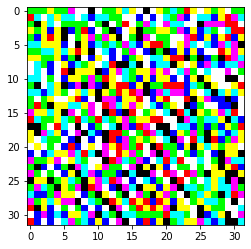

In [ ]:
plt.subplot(110 + 1)
plt.imshow(perturbation[0] * 255)
plt.show

The efficiency of this perturbation on CIFAR-10 dataset

To increase the efficiency, change the value of 'percent' and 'epsilon' before generating the perturbation

In [ ]:
error = 0

p = perturbation * 0.5

for index in range(0,50000):
  img     = x_train[index:index+1]
  img     = img + (p)
  label   = y_train[index][0]
  y_pred  = np.argmax(model.predict(img)[0])

  if y_pred != label:
    error += 1

print(error/50000)

0.5738


In [ ]:
errorMap    = {}
correctMap  = {}

for index in range(0,1000):
  label = y_test[index][0]

  if label not in errorMap:
    img     = x_test[index:index+1]
    advImg  = copy.deepcopy(img) + (perturbation * 0.5)
    y_pred  = np.argmax(model.predict(img)[0])

    if y_pred != label:
      errorMap[label] = (img, advImg, label, y_pred)
    elif label not in correctMap and y_pred == label:
      correctMap[label] = (img, advImg, label, y_pred)
  
  if len(errorMap) == 10 and len(correctMap) == 10:
    break

In [ ]:
def displayImages(orgImg, advImg):
  plt.subplot(220 + 1)
  plt.imshow(orgImg[0])
  plt.subplot(220 + 2)
  plt.imshow(advImg[0])
  plt.show()

Successful adversarial examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


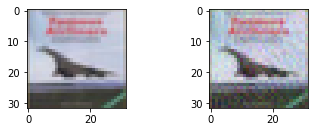

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original class: airplane  Perturbed class: ship


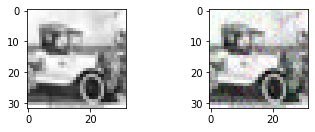

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original class: automobile  Perturbed class: truck


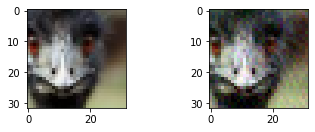

Original class: bird  Perturbed class: automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


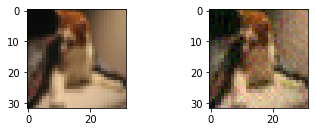

Original class: cat  Perturbed class: dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


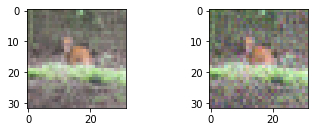

Original class: deer  Perturbed class: bird


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


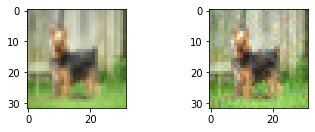

Original class: dog  Perturbed class: deer


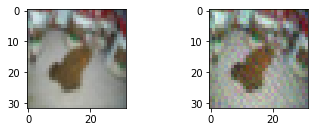

Original class: frog  Perturbed class: cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


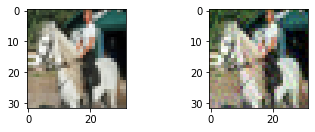

Original class: horse  Perturbed class: dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


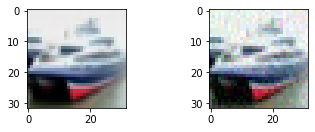

Original class: ship  Perturbed class: automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


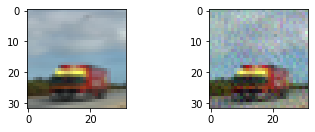

Original class: truck  Perturbed class: ship


In [ ]:
for index in range(0,10):
  data = errorMap[index]

  displayImages(data[0], data[1])
  print('Original class:', class_names[data[2]],' Perturbed class:', class_names[data[3]])

Failed adversarial examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


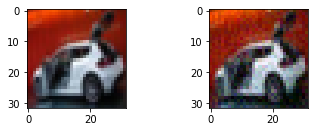

Left image class: automobile  Right image class: automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


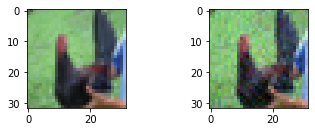

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Left image class: bird  Right image class: bird


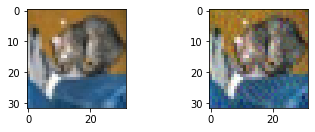

Left image class: cat  Right image class: cat


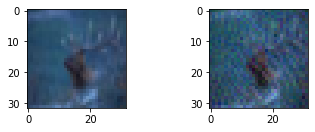

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Left image class: deer  Right image class: deer


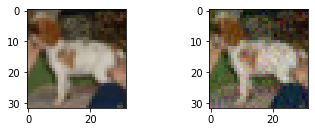

Left image class: dog  Right image class: dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


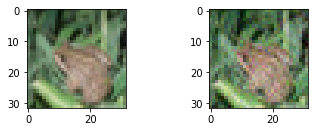

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Left image class: frog  Right image class: frog


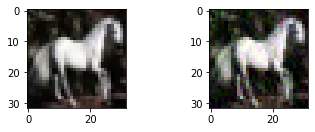

Left image class: horse  Right image class: horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


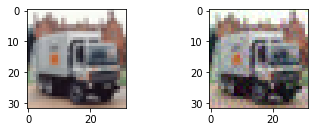

Left image class: truck  Right image class: truck


In [ ]:
for index in range(0,10):
  if index in correctMap:
    data = correctMap[index]
    displayImages(data[0], data[1])
    print('Left image class:', class_names[data[2]],' Right image class:', class_names[data[3]])